### Загрузка данных

Гайд по скачиванию:
https://www.metagenomics.wiki/tools/fastq/ncbi-ftp-genome-download

In [74]:
import gzip

!wget 'https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/355/675/GCF_000355675.1_ASM35567v1/GCF_000355675.1_ASM35567v1_genomic.fna.gz'
!wget 'https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/355/675/GCF_000355675.1_ASM35567v1/GCF_000355675.1_ASM35567v1_genomic.gbff.gz'

!gunzip GCF_000355675.1_ASM35567v1_genomic.fna.gz
!gunzip GCF_000355675.1_ASM35567v1_genomic.gbff.gz

--2023-11-12 16:22:58--  https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/355/675/GCF_000355675.1_ASM35567v1/GCF_000355675.1_ASM35567v1_genomic.fna.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.10, 130.14.250.11, 2607:f220:41e:250::11, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1168222 (1.1M) [application/x-gzip]
Saving to: ‘GCF_000355675.1_ASM35567v1_genomic.fna.gz’

GCF_000355675.1_ASM 100%[===================>]   1.11M  --.-KB/s    in 0.1s    

2023-11-12 16:22:58 (10.9 MB/s) - ‘GCF_000355675.1_ASM35567v1_genomic.fna.gz’ saved [1168222/1168222]

--2023-11-12 16:22:58--  https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/355/675/GCF_000355675.1_ASM35567v1/GCF_000355675.1_ASM35567v1_genomic.gbff.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.10, 130.14.250.11, 2607:f220:41e:250::11, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nl

### Reading sequences

In [75]:
!pip install bio

In [76]:
from Bio import SeqIO
from Bio.Seq import Seq
import numpy as np
import pandas as pd
from itertools import product
import matplotlib.pyplot as plt

seq = None
gb = None

# считываем скачанные файлы
for record in SeqIO.parse("/content/GCF_000355675.1_ASM35567v1_genomic.fna", "fasta"):
    seq = record.seq

for record in SeqIO.parse('/content/GCF_000355675.1_ASM35567v1_genomic.gbff', 'genbank'):
  gb = record

In [77]:
start, end = gb.features[0].location.start, None

ncod = []
cod = []

# записываем кодирующие и некодирующие последовательности
for i in range(len(gb.features)):
  feature = gb.features[i]
  fseq = feature.extract(seq)

  end = feature.location.start

  if feature.type == 'CDS' and fseq[:3] == 'ATG' and len(fseq) % 3 == 0:
    cod.append(fseq.__str__())

    if len(seq[start:end]) != 0:
      ncod.append(seq[start:end].__str__())

    start = feature.location.end

### Initial probabilities

In [78]:
"""
Высчитываем единичные вероятности
"""

def seq_probs(seq):
  return np.array([
      seq.count('T'), seq.count('C'),
      seq.count('A'), seq.count('G')
    ]) / len(seq)

def cod_probs(seq):
  res = []
  for i in range(3):
    res.append(seq_probs(seq[i::3]))
  return np.array(res)

def make_table1(cod_seqs, ncod_seqs):
  table1 = pd.DataFrame(np.vstack((cod_probs(''.join(cod_seqs)), seq_probs(''.join(ncod_seqs)))).T,
                       index=['T', 'C', 'A', 'G'],
                       columns=[f'pos{i}' for i in range(1, 4)] + ['nc'])
  return table1

In [79]:
t1 = make_table1(cod, ncod)
t1

,pos1,pos2,pos3,nc
T,0.181178,0.296080,0.315009,0.272761
C,0.206735,0.227039,0.233246,0.228978
A,0.256919,0.302102,0.238526,0.276553
G,0.355168,0.174779,0.213219,0.221708


### Transition probabilities

In [80]:
"""
Высчитываем вероятности первого порядка
"""

def cod_dprobs(seqs):
  dcounts = dict(
    zip([1, 2, 3],
        [dict(zip([''.join(pair) for pair in product('TCAG', repeat=2)],
                  [0] * 16)) for i in range(3)])
    )
  for seq in seqs:
    for i in range(1, len(seq)):
      dcounts[i % 3 + 1][seq[i-1:i+1]] += 1
  return get_probs(dcounts)

def ncod_dprobs(seqs):
    dcounts =dict(zip([''.join(pair) for pair in product('TCAG', repeat=2)],
                    [0] * 16))
    for seq in seqs:
      for i in range(1, len(seq)):
        dcounts[seq[i-1:i+1]] += 1

    return get_probs({0: dcounts})[0]

def get_probs(dcounts):
  for pos in dcounts:
    nuc_groups = dict(zip('TCAG', [0] * 4))
    for dup in dcounts[pos]:
      nuc_groups[dup[0]] += dcounts[pos][dup]
    for dup in dcounts[pos]:
      dcounts[pos][dup] /= nuc_groups[dup[0]]
  return dcounts

def make_table2(cod_seqs, ncod_seqs):
  table2 = pd.DataFrame(cod_dprobs(cod_seqs))
  table2[4] = pd.Series(ncod_dprobs(ncod_seqs))
  table2.rename(columns=dict(zip(np.arange(1, 5),
                                 [f'pos{i}' for i in range(1, 4)] + ['nc'])),
                inplace=True)
  table2.index = [prob_notation(idx) for idx in table2.index.values]
  return table2

def prob_notation(st):
  return st[1] + '|' + st[0]

In [81]:
t2 = make_table2(cod, ncod)
t2

,pos1,pos2,pos3,nc
T|T,0.185527,0.497941,0.316282,0.317919
C|T,0.189643,0.199367,0.179967,0.209093
A|T,0.249195,0.172458,0.221521,0.243747
G|T,0.375635,0.130234,0.282230,0.229240
T|C,0.185286,0.248599,0.269786,0.252206
C|C,0.156258,0.198068,0.244280,0.213760
A|C,0.276169,0.315114,0.244600,0.286907
G|C,0.382287,0.238219,0.241334,0.247126
T|A,0.179924,0.333963,0.307865,0.269894
C|A,0.194132,0.213885,0.193588,0.205527


**Training example** :
TATTACTTC

In [ ]:
P_seq_nc = t1['nc']['T'] * t2['nc']['A|T']*t2['nc']['T|A']*t2['nc']['T|T']*t2['nc']['A|T']*t2['nc']['C|A']*t2['nc']['T|C']*t2['nc']['T|T']*t2['nc']['C|T']
P_seq_nc

4.7912814510831735e-06

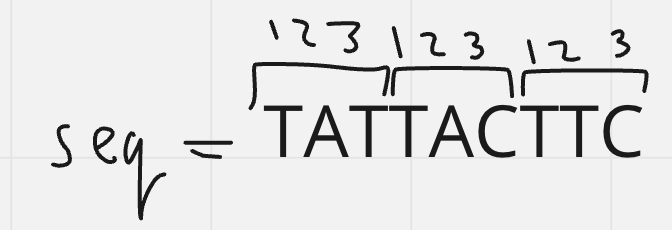

In [ ]:
P_seq_cod = t1['pos1']['T']   * t2['pos2']['A|T'] * t2['pos3']['T|A'] * \
            t2['pos1']['T|T'] * t2['pos2']['A|T'] * t2['pos3']['C|A'] * \
            t2['pos1']['T|C'] * t2['pos2']['T|T'] * t2['pos3']['C|T']
P_seq_cod

9.893054273008876e-07

In [ ]:
P_nc = 0.5
P_cod = 0.5
P_nc_seq = P_nc * P_seq_nc / (P_nc * P_seq_nc + P_cod * P_seq_cod)
P_nc_seq

0.8288572686278104

In [ ]:
P_cod_seq = P_cod * P_seq_cod / (P_nc * P_seq_nc + P_cod * P_seq_cod)
P_cod_seq

0.17114273137218963

In [ ]:
1-P_nc_seq

0.1711427313721896

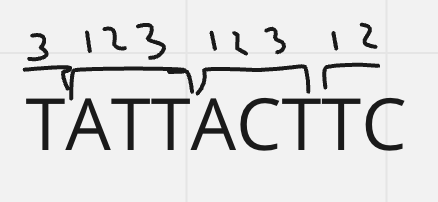

In [ ]:
P_seq_cod2 = t1['pos3']['T'] * \
            t2['pos1']['A|T'] * t2['pos2']['T|A'] * t2['pos3']['T|T'] * \
            t2['pos1']['A|T'] * t2['pos2']['C|A'] * t2['pos3']['T|C'] * \
            t2['pos1']['T|T'] * t2['pos2']['C|T']
P_seq_cod2

4.397316710439334e-06

### Prediction

In [82]:
"""
Высчитываем кодирующие вероятности для последовательностей
"""

def cod_proba(seq, t1, t2, frame=1):

  if len(seq) == 0:
    print('No sequence')
    return None

  if frame not in [1, 2, 3]:
    print('No such frame')
    return None

  previous_nuc = seq[0]
  start_pos = None
  previous_pos = 1
  if frame == 1:
    previous_pos = 1
  elif frame == 2:
    previous_pos = 2
  else: previous_pos = 3

  log_prob = np.log(t1[t1.columns[previous_pos - 1]][seq[0]])
  previous_nuc = seq[0]
  for i, nuc in enumerate(seq[1:]):
    pair = '{}|{}'.format(nuc, previous_nuc)
    if (previous_pos) % 3 == 0:
      previous_pos = 1
    else:
      previous_pos += 1
    log_prob += np.log(t2[t2.columns[previous_pos - 1]][pair])
    previous_nuc = nuc
  prob = np.exp(log_prob)
  return prob

"""
Высчитываем некодирующие вероятности для последовательностей
"""

def ncod_proba(seq, t1, t2):
  if len(seq) == 0:
    print('No sequence')
    return None

  log_prob_nc=np.log(t1['nc'][seq[0]])
  prev_nuc = seq[0]
  for i, nuc in enumerate(seq[1:]):
    pair = '{}|{}'.format(nuc, prev_nuc)
    log_prob_nc += np.log(t2['nc'][pair])
    prev_nuc = nuc
  prob_nc = np.exp(log_prob_nc)
  return prob_nc

"""
Высчитываем общие вероятности для последовательностей
"""

def get_cod_probs(seq, t1, t2):
  prob1 = cod_proba(seq, t1, t2, frame=1)
  prob2 = cod_proba(seq, t1, t2, frame=2)
  prob3 = cod_proba(seq, t1, t2, frame=3)
  probnc = ncod_proba(seq, t1, t2)

  prob_seq = prob1 + prob2 + prob3 + probnc
  res1 =  prob1 / prob_seq
  res2 = prob2 / prob_seq
  res3 = prob3 / prob_seq
  resnc = probnc / prob_seq

  return [res1, res2, res3, resnc]

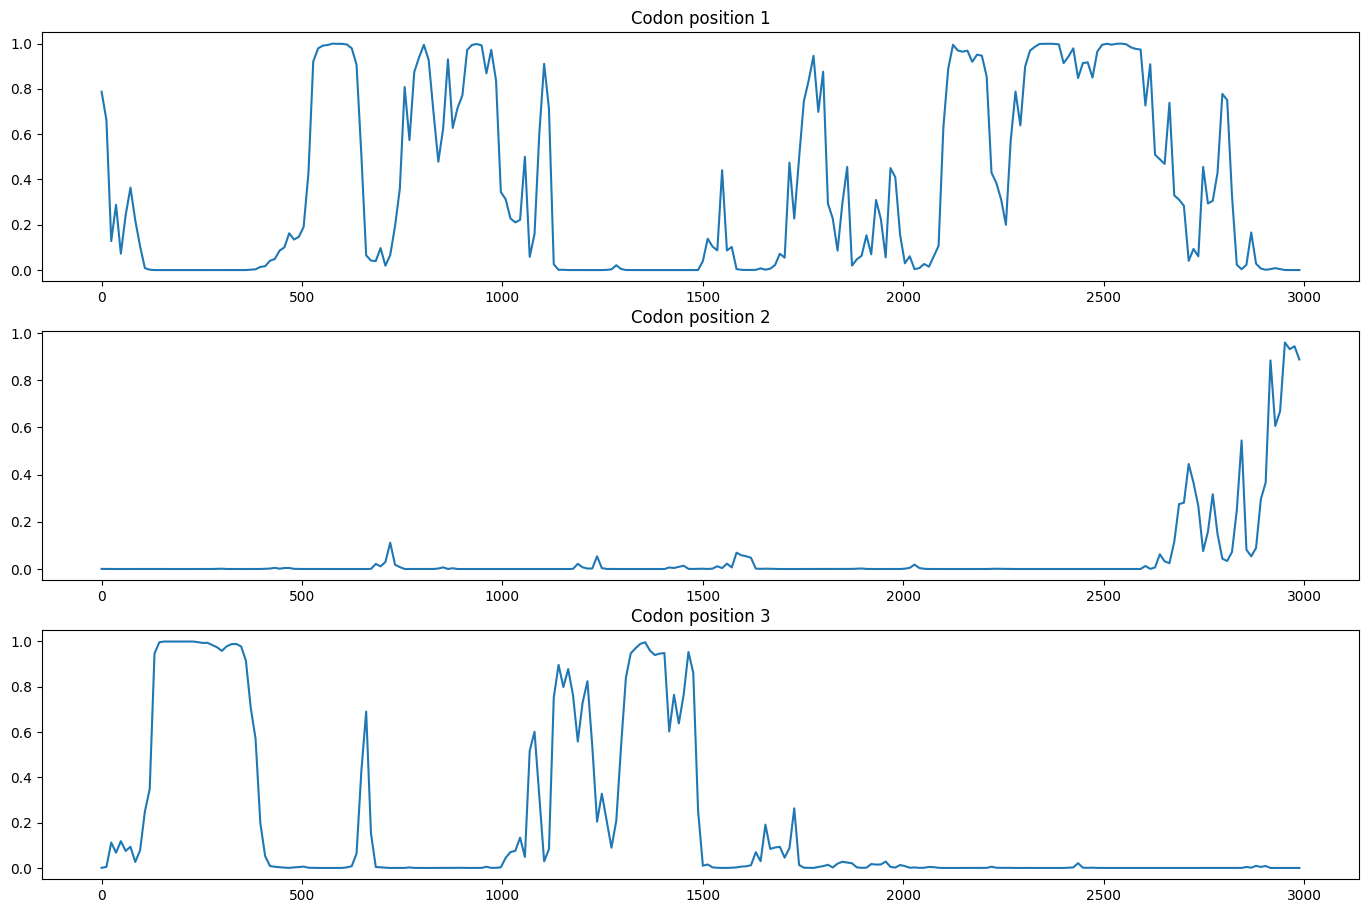

In [83]:
"""
Выводим три графика для каждого из фреймов (выводить некодирующий не надо - если сложить все 4 графика получится единица)
"""

def plot_graph(data, start, end, step):
  fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(17, 11))

  x = range(start, end, step)

  ax1.plot(x, data[:,0])
  ax2.plot(x, data[:,1])
  ax3.plot(x, data[:,2])

  ax1.set_title('Codon position 1')
  ax2.set_title('Codon position 2')
  ax3.set_title('Codon position 3')

  plt.plot()

seq1 = seq[7900:7900+3096] #выбрали последовательность которая целиком на плюс стренде
start = 0
end = 3000
step = 12
window = 96
pos_probs = list()
for i in range(start, end, step):
  pos_probs.append(get_cod_probs(seq1[i:i + window], t1, t2))
pos_probs = np.array(pos_probs)

plot_graph(pos_probs, start, end, step)

In [84]:
"""
Высчитываем общие вероятности для последовательностей на обоих стрендах
"""

def get_bothstrand_cod_probs(seq, t1, t2):
  prob1 = cod_proba(seq, t1, t2, frame=1)
  prob2 = cod_proba(seq, t1, t2, frame=2)
  prob3 = cod_proba(seq, t1, t2, frame=3)
  probnc = ncod_proba(seq, t1, t2)

  rev_seq = Seq(seq).reverse_complement()
  rev_prob1 = cod_proba(rev_seq, t1, t2, frame=1)
  rev_prob2 = cod_proba(rev_seq, t1, t2, frame=2)
  rev_prob3 = cod_proba(rev_seq, t1, t2, frame=3)

  prob_seq_rev = prob1 + prob2 + prob3 + rev_prob1 + rev_prob2 + rev_prob3 + probnc
  res1 = prob1 / prob_seq_rev
  res2 = prob2 / prob_seq_rev
  res3 = prob3 / prob_seq_rev
  rev_res1 = rev_prob1 / prob_seq_rev
  rev_res2 = rev_prob2 / prob_seq_rev
  rev_res3 = rev_prob3 / prob_seq_rev
  resnc = probnc / prob_seq_rev

  return [res1, res2, res3, rev_res1, rev_res2, rev_res3, resnc]

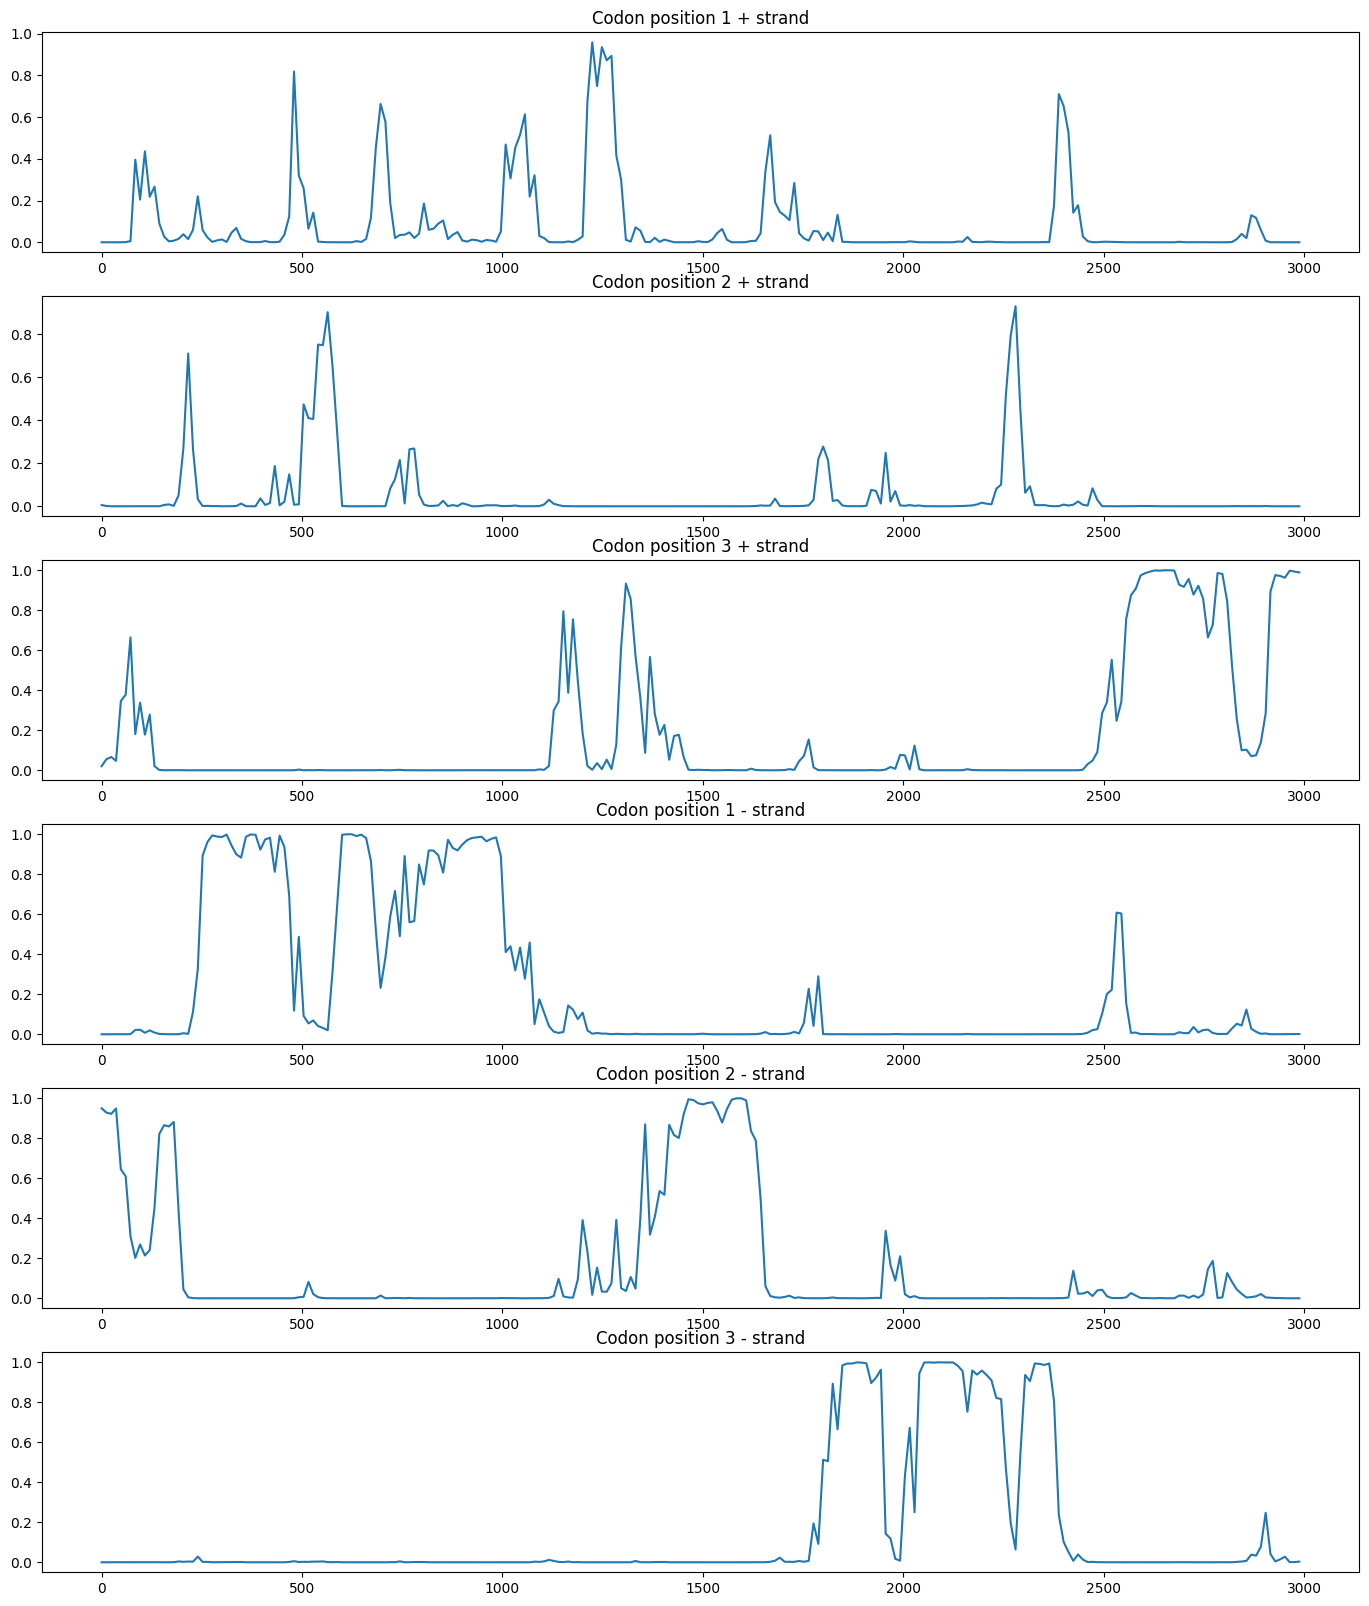

In [85]:
"""
Выводим шесть графиков для каждого из фреймов
"""

def plot_bothstrand_graph(data, start, end, step):
  fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1, figsize=(17, 20))

  x = range(start, end, step)

  ax1.plot(x, data[:, 0])
  ax1.set_title('Codon position 1 + strand')
  ax2.plot(x, data[:, 1])
  ax2.set_title('Codon position 2 + strand')
  ax3.plot(x, data[:, 2])
  ax3.set_title('Codon position 3 + strand')
  ax4.plot(x, data[:, 3])
  ax4.set_title('Codon position 1 - strand')
  ax5.plot(x, data[:, 4])
  ax5.set_title('Codon position 2 - strand')
  ax6.plot(x, data[:, 5])
  ax6.set_title('Codon position 3 - strand')

  plt.plot()

seq2 = seq[31000:31000+3096] #выбрали последовательность которая и на плюс и на минус стренде
start = 0
end = 3000
step = 12
window = 96
pos_probs = []
for i in range(start, end, step):
  pos_probs.append(get_bothstrand_cod_probs(seq2[i:i+window], t1, t2))
pos_probs = np.array(pos_probs)

plot_bothstrand_graph(pos_probs, start, end, step)